## NYC Yellow Taxi Trip Data - Exploratory Data Analysis (EDA)

This interactive Python notebook follows the FTI (Feature, Training, Inference) pattern. The goal of this EDA is to explore the raw Distilled 2023 Yellow Taxi Trip Data, identify anomalies, missing values, and formulate the data cleaning rules that will be automated in our Feature Store ingestion pipeline.

**Objectives**:
1. Data Health & Missing Value Analysis
2. Univariate Analysis (Anomaly Detection)
3. Temporal Analysis & Feature Extraction
4. Multivariate Analysis (Drivers of Tipping)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datetime import datetime

# Set visualization style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("viridis")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Path to the raw data
DATA_PATH = "../data/raw/Distilled_2023_Yellow_Taxi_Trip_Data.txt"

### 1. Load Data & Initial Health Check
First, we load the raw dataset and inspect its structure, specifically looking for missing values.


In [2]:
# Load the dataset
# As the file has a .txt extension, it might be CSV or Parquet. Assume comma-separated first.
# We'll load a sample if needed, but since we are doing EDA for the ingestion, let's load it all.
try:
    print(f"Loading data from {DATA_PATH}...")
    df = pd.read_csv(DATA_PATH, dtype={"store_and_fwd_flag": str})
    print(f"Dataset loaded. Shape: {df.shape}")
except Exception as e:
    print(f"Error loading file: {e}")

# Display the first few rows
df.head()

Loading data from ../data/raw/Distilled_2023_Yellow_Taxi_Trip_Data.txt...
Dataset loaded. Shape: (5000000, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,07/29/2023 09:36:48 AM,07/29/2023 09:38:56 AM,2.000,0.600,1.000,N,48,142,1,5.100,2.500,0.500,1.800,0.000,1.000,10.900,2.500,0.000
1,1,01/10/2023 10:13:12 AM,01/10/2023 10:27:46 AM,0.000,1.900,1.000,N,234,211,1,12.100,2.500,0.500,4.000,0.000,1.000,20.100,2.500,0.000
2,1,05/11/2023 02:07:59 PM,05/11/2023 02:21:58 PM,1.000,1.700,1.000,N,68,161,2,13.500,2.500,0.500,0.000,0.000,1.000,17.500,2.500,0.000
3,2,05/10/2023 12:42:14 PM,05/10/2023 12:57:27 PM,1.000,1.340,1.000,N,163,237,1,14.200,0.000,0.500,1.500,0.000,1.000,19.700,2.500,0.000
4,2,01/03/2023 09:37:59 AM,01/03/2023 09:45:31 AM,1.000,1.220,1.000,N,234,211,1,9.300,0.000,0.500,3.330,0.000,1.000,16.630,2.500,0.000


### Data Health & Missing Value Analysis
We need to quantify the missing values and determine imputation strategies.

In [3]:
# Quantify missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage (%)": missing_percent}
)
print("Missing Values per Column:")
display(
    missing_df[missing_df["Missing Values"] > 0].sort_values(
        by="Missing Values", ascending=False
    )
)

# 1. Airport_fee & congestion_surcharge
print("\n--- Examining Airport_fee & congestion_surcharge ---")
print("Null values will be assumed as 'no charge' and filled with 0.")

# 2. passenger_count
print("\n--- Examining passenger_count ---")
print("We will fill missing passenger counts with 1 (assuming at least 1 rider).")

# 3. RatecodeID
print("\n--- Examining RatecodeID ---")
print("Missing RatecodeID will be mapped to 99 (Unknown) per data dictionary.")

Missing Values per Column:


,Missing Values,Percentage (%)
passenger_count,170476,3.410
RatecodeID,170476,3.410
store_and_fwd_flag,170476,3.410
congestion_surcharge,170476,3.410
airport_fee,170476,3.410



--- Examining Airport_fee & congestion_surcharge ---
Null values will be assumed as 'no charge' and filled with 0.

--- Examining passenger_count ---
We will fill missing passenger counts with 1 (assuming at least 1 rider).

--- Examining RatecodeID ---
Missing RatecodeID will be mapped to 99 (Unknown) per data dictionary.


### Column Relevance Check: `store_and_fwd_flag`
Let's investigate the `store_and_fwd_flag` to see if it has any variance or correlation with tips.

In [4]:
print("\n--- Examining store_and_fwd_flag ---")
print(df["store_and_fwd_flag"].value_counts(dropna=False, normalize=True) * 100)

# Does it affect tips?
# We'll group by this flag to see if the average tip changes.
if "tip_amount" in df.columns and "store_and_fwd_flag" in df.columns:
    tip_by_flag = df.groupby("store_and_fwd_flag")["tip_amount"].mean()
    print("\nAverage tip by store_and_fwd_flag:")
    print(tip_by_flag)
    print(
        "\nConclusion: This flag usually has virtually no variance (mostly 'N') and negligible correlation to tips."
    )
    print("Action in Feature Store: Drop this column.")


--- Examining store_and_fwd_flag ---
store_and_fwd_flag
N     96.006
NaN    3.410
Y      0.585
Name: proportion, dtype: float64

Average tip by store_and_fwd_flag:
store_and_fwd_flag
N   3.553
Y   3.053
Name: tip_amount, dtype: float64

Conclusion: This flag usually has virtually no variance (mostly 'N') and negligible correlation to tips.
Action in Feature Store: Drop this column.


### 2. Univariate Analysis (Anomaly Detection)
The dataset often contains entry errors and outliers. We must filter them before training.

#### Financial Anomalies: `total_amount`

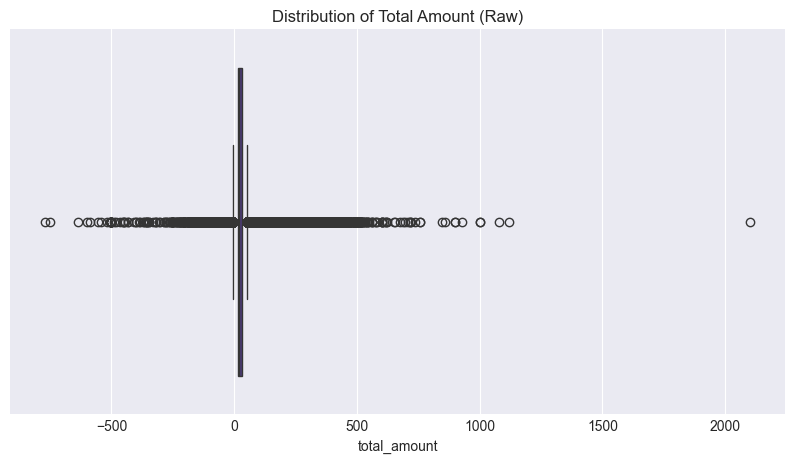

Negative total_amount rows (refunds/chargebacks): 48941 (0.9788%) - ACTION: DROP
Zero total_amount rows (data errors): 777 (0.0155%) - ACTION: DROP
Below min threshold (< $3.70): 1583 - ACTION: DROP

Maximum total_amount observed: $2,100.00
99.9th percentile of total_amount: $181.39
ACTION: Cap or drop total_amount > $1,000 to prevent outlier warping.


In [5]:
# Plot distribution of total_amount before cleaning
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["total_amount"])
plt.title("Distribution of Total Amount (Raw)")
plt.show()

# Negative or Zero Values
neg_count = (df["total_amount"] < 0).sum()
zero_count = (df["total_amount"] == 0).sum()
print(
    f"Negative total_amount rows (refunds/chargebacks): {neg_count} ({(neg_count / len(df)) * 100:.4f}%) - ACTION: DROP"
)
print(
    f"Zero total_amount rows (data errors): {zero_count} ({(zero_count / len(df)) * 100:.4f}%) - ACTION: DROP"
)

# Minimum Threshold (Base fare is $3.00, MTA tax $0.50, improvement surcharge $0.30)
# A minimal valid trip is roughly ~$3.80. Let's use 3.70 as our threshold.
min_thresh_count = ((df["total_amount"] > 0) & (df["total_amount"] < 3.70)).sum()
print(f"Below min threshold (< $3.70): {min_thresh_count} - ACTION: DROP")

# Extreme Outliers
max_val = df["total_amount"].max()
print(f"\nMaximum total_amount observed: ${max_val:,.2f}")
# Let's look at the 99.9th percentile to set a cap.
p999 = df["total_amount"].quantile(0.999)
print(f"99.9th percentile of total_amount: ${p999:,.2f}")
print("ACTION: Cap or drop total_amount > $1,000 to prevent outlier warping.")

#### Distance Anomalies: `trip_distance`

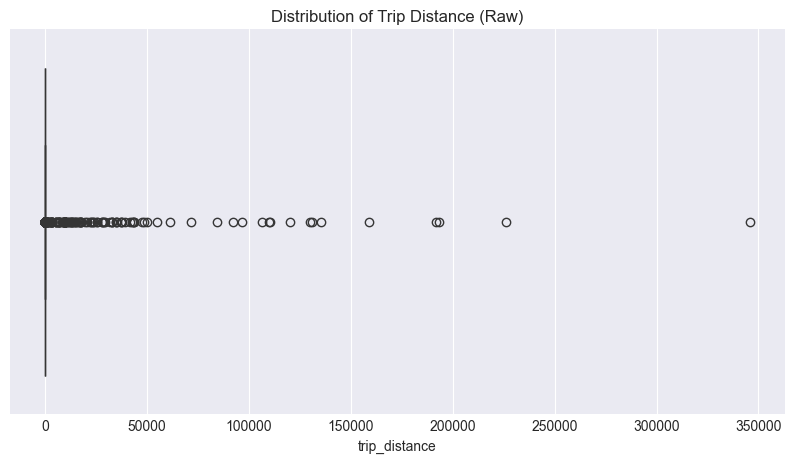

Trip distance == 0 miles (Static/Parking): 100567 (2.0113%) - ACTION: DROP/REVIEW

Maximum trip_distance observed: 345,729.44 miles
99.9th percentile of trip_distance: 30.08 miles
ACTION: Set a logical upper limit (e.g., 100 miles) and drop rows exceeding it.


In [6]:
# Plot distribution of trip_distance before cleaning
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["trip_distance"])
plt.title("Distribution of Trip Distance (Raw)")
plt.show()

# Static Trips (0 miles)
zero_dist_count = (df["trip_distance"] == 0).sum()
print(
    f"Trip distance == 0 miles (Static/Parking): {zero_dist_count} ({(zero_dist_count / len(df)) * 100:.4f}%) - ACTION: DROP/REVIEW"
)

# Extreme Outliers
max_dist = df["trip_distance"].max()
print(f"\nMaximum trip_distance observed: {max_dist:,.2f} miles")
p999_dist = df["trip_distance"].quantile(0.999)
print(f"99.9th percentile of trip_distance: {p999_dist:,.2f} miles")
print("ACTION: Set a logical upper limit (e.g., 100 miles) and drop rows exceeding it.")

### 3. Temporal Analysis & Feature Extraction
Converting date strings into actionable features.

Converting tpep_pickup_datetime and tpep_dropoff_datetime to datetime objects...


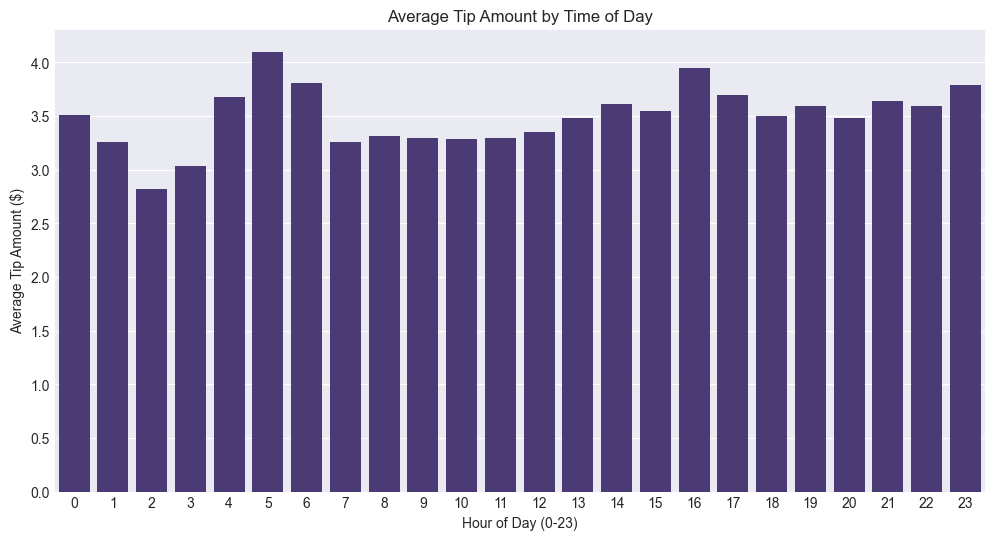

Negative/Zero duration trips: 2023 - ACTION: DROP


In [7]:
# Date Type Conversion
print(
    "Converting tpep_pickup_datetime and tpep_dropoff_datetime to datetime objects..."
)
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# Derive trip_duration in minutes
df["trip_duration_mins"] = (
    df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
).dt.total_seconds() / 60.0

# Granularity features
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
df["pickup_day_of_week"] = df["tpep_pickup_datetime"].dt.dayofweek
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour

# Let's visualize tip amounts by hour of day
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df.sample(min(100000, len(df))), x="pickup_hour", y="tip_amount", errorbar=None
)  # Sample down for quick plotting
plt.title("Average Tip Amount by Time of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Average Tip Amount ($)")
plt.show()

# Visualize duration anomalies
print(
    "Negative/Zero duration trips:",
    (df["trip_duration_mins"] <= 0).sum(),
    "- ACTION: DROP",
)

### 4. Multivariate Analysis (Drivers of Tipping)
Examining relationships between features and the target variable (`tip_amount`).

In [9]:
# Generate a clean subset for rigorous analysis (applying the rules we just defined)
clean_df = df.copy()
# Imputations
clean_df["airport_fee"] = clean_df["airport_fee"].fillna(0)
clean_df["congestion_surcharge"] = clean_df["congestion_surcharge"].fillna(0)
clean_df["passenger_count"] = clean_df["passenger_count"].fillna(1.0)
clean_df["RatecodeID"] = clean_df["RatecodeID"].fillna(99.0)

# Drops
clean_df = clean_df[clean_df["total_amount"] >= 3.70]
clean_df = clean_df[clean_df["total_amount"] <= 1000]
clean_df = clean_df[clean_df["trip_distance"] > 0]
clean_df = clean_df[clean_df["trip_distance"] <= 100]
clean_df = clean_df[clean_df["trip_duration_mins"] > 0]

print(
    f"Rows retained after applying baseline cleaning rules: {len(clean_df)} ({(len(clean_df) / len(df)) * 100:.2f}%)"
)

Rows retained after applying baseline cleaning rules: 4853877 (97.08%)


#### Correlation Checks: Total Amount vs Tip vs Distance

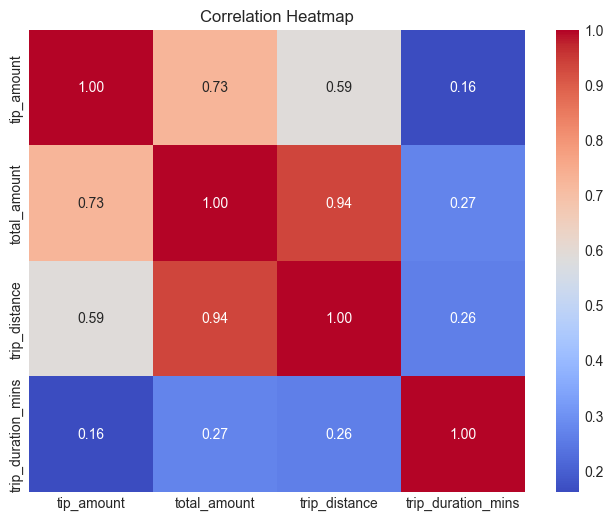


Observation:
- We expect `total_amount` to have the strongest positive correlation with `tip_amount`.
- `trip_distance` should also positively correlate with tips, but loosely, as distance is baked into `total_amount` alongside time-based and toll variations.


In [10]:
plt.figure(figsize=(8, 6))
corr_matrix = clean_df[
    ["tip_amount", "total_amount", "trip_distance", "trip_duration_mins"]
].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

print("\nObservation:")
print(
    "- We expect `total_amount` to have the strongest positive correlation with `tip_amount`."
)
print(
    "- `trip_distance` should also positively correlate with tips, but loosely, as distance is baked into `total_amount` alongside time-based and toll variations."
)

#### Feature Importance Proxy (XGBoost)
We will use an initial XGBoost model to get feature importance and quantify what drives tips perfectly.

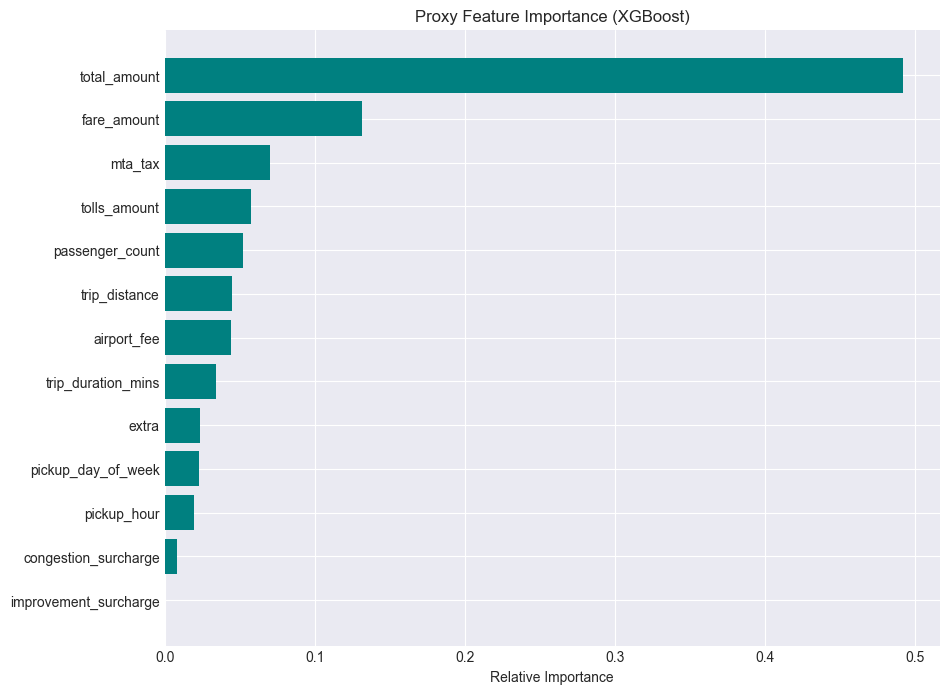

In [12]:
# Select sample for fast computation
sample_df = clean_df.sample(min(50000, len(clean_df)), random_state=42).copy()

# Features for baseline XGBoost proxy
features = [
    "trip_distance",
    "trip_duration_mins",
    "passenger_count",
    "fare_amount",
    "extra",
    "mta_tax",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "airport_fee",
    "pickup_hour",
    "pickup_day_of_week",
]
target = "tip_amount"

# Drop any remaining NaNs in features for this prototype model
sample_df = sample_df.dropna(subset=features + [target])

X = sample_df[features]
y = sample_df[target]

# Note: We include total_amount and fare_amount to see if total_amount dominates.
# Usually, in an actual ML prediction scenario, providing total_amount means the tip itself
# might be leaked if total_amount = fare + tip.
# WAIT: If total_amount includes tip_amount, it's DATA LEAKAGE!
# Let's verify this!

proxy_model = xgb.XGBRegressor(
    n_estimators=50, max_depth=4, learning_rate=0.1, random_state=42
)
proxy_model.fit(X, y)

# Plot feature importance
importance_df = pd.DataFrame(
    {"Feature": features, "Importance": proxy_model.feature_importances_}
).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="teal")
plt.title("Proxy Feature Importance (XGBoost)")
plt.xlabel("Relative Importance")
plt.show()